<a href="https://colab.research.google.com/github/top-data/Soil_moisture/blob/main/sm_cosmoz_inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and authentication

In [1]:
# libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import folium
import geemap
from datetime import datetime, timedelta
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score





In [2]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize(project='ee-mhdsaki')


# Functions for building dataset

In [4]:
# General function to fetch data from any satellite product
def fetch_satellite_data(start_date, end_date, sat_product, bands, gps, is_temporal=True):
    """
    Fetch satellite data from Google Earth Engine and return it as a Pandas DataFrame.

    Parameters:
    - start_date: Start date for the image collection (format: 'YYYY-MM-DD') - only used for temporal products.
    - end_date: End date for the image collection (format: 'YYYY-MM-DD') - only used for temporal products.
    - sat_product: Earth Engine satellite product name (e.g., 'MODIS/061/MOD11A2' or 'CGIAR/SRTM90_V4').
    - bands: List of bands to select (e.g., ['LST_Day_1km']).
    - gps: List or tuple of GPS coordinates for the point of interest (e.g., [longitude, latitude]).
    - is_temporal: Boolean flag to indicate if the product is temporal (default: True).

    Returns:
    - Pandas DataFrame with the extracted band values, image date, GPS, and satellite product information.
    """
    region = ee.Geometry.Point(gps)  # Define the region of interest (point based on the GPS coordinates)

    if is_temporal:
        # Step 1: Load the temporal satellite product (Image Collection) and filter by date
        dataset = ee.ImageCollection(sat_product).filter(ee.Filter.date(start_date, end_date))
    else:
        # Step 1: Load the non-temporal satellite product (single image)
        dataset = ee.Image(sat_product)

    # Step 2: Select the desired bands
    selected_bands = dataset.select(bands)

    # Step 3: Function to extract mean values for the selected bands along with the date (only for temporal products)
    def extract_band_values(image):
        mean_image = image.reduceRegion(
            reducer=ee.Reducer.mean(),  # Mean reduction over the region
            geometry=region,
            scale=1000,  # Adjust scale based on the satellite product resolution
            maxPixels=1e9
        )

        # Get the date of the image (only for temporal products)
        if is_temporal:
            date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
        else:
            date = 'N/A'  # No date for non-temporal products

        # Create a feature with the image's date and mean values
        feature_data = mean_image.set('date', date)
        return ee.Feature(None, feature_data)

    # Step 4: Map the extraction function over the image collection (for temporal products)
    if is_temporal:
        extracted_data = selected_bands.map(extract_band_values)
    else:
        # Apply extraction function for a single image (non-temporal)
        extracted_data = extract_band_values(selected_bands).getInfo()

    # Step 5: Convert the extracted data to a Pandas DataFrame
    if is_temporal:
        data = extracted_data.getInfo()
        df = pd.DataFrame([{
            **feature['properties'],  # All band values and the date
            'sat_product': sat_product,  # Add satellite product
            'gps': gps  # Add GPS coordinates
        } for feature in data['features']])
    else:
        # For non-temporal products, handle extraction differently
        df = pd.DataFrame([{
            **extracted_data['properties'],  # Band values without the date
            'date': 'N/A',  # No date for non-temporal products
            'sat_product': sat_product,  # Add satellite product
            'gps': gps  # Add GPS coordinates
        }])

    return df

# Modify the download_sat_data function to accept a new parameter for non-temporal products
def download_sat_data(start_date, end_date, sat_product, bands, gps, is_temporal=True):
    return fetch_satellite_data(start_date, end_date, sat_product, bands, gps, is_temporal)

# Adjust build_sat_data to pass the is_temporal flag
def build_sat_data(station_lookup_table, start_date, end_date, sat_product, bands, is_temporal=True):
    gps = [station_lookup_table['lon'], station_lookup_table['lat']]

    # Empty list to store DataFrames
    dfs = []

    if is_temporal:
        # Loop through the date range in 3-month intervals for temporal products
        current_start = start_date
        while current_start < end_date:
            current_end = min(current_start + timedelta(days=90), end_date)
            df = download_sat_data(current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d'), sat_product, bands, gps, is_temporal)
            dfs.append(df)
            current_start = current_end
    else:
        # For non-temporal products, we only need to fetch the data once
        df = download_sat_data(None, None, sat_product, bands, gps, is_temporal)
        dfs.append(df)

    # Combine all DataFrames into one
    sat_df = pd.concat(dfs)

    # Add station site_no and site_name to the DataFrame
    sat_df['site_no'] = station_lookup_table['site_no']
    sat_df['site_name'] = station_lookup_table['site_name']

    # Process the combined DataFrame
    sat_df['date'] = pd.to_datetime(sat_df['date'], errors='coerce')  # Convert 'date' to datetime
    sat_df.set_index('date', inplace=True, drop=False)  # Set 'date' as index if temporal

    # Keep non-numeric columns (site_no, site_name, gps, sat_product)
    non_numeric_cols = sat_df[['site_no', 'site_name', 'gps', 'sat_product']]
    non_numeric_cols = non_numeric_cols[~non_numeric_cols.index.duplicated(keep='first')]

    # Resample sat_df to daily, averaging numeric columns (only if temporal)
    if is_temporal:
        sat_df_daily = sat_df.resample('D').mean(numeric_only=True)
        # Re-merge non-numeric columns back into sat_df_daily using forward-fill
        non_numeric_cols = non_numeric_cols.resample('D').ffill()
        sat_df_daily = pd.concat([sat_df_daily, non_numeric_cols], axis=1)
    else:
        sat_df_daily = sat_df  # For non-temporal products, we skip resampling

    return sat_df_daily

# Adjust merge_sat_for_all_stations to pass the is_temporal flag
def merge_sat_for_all_stations(station_lookup_table, start_date, end_date, sat_product, bands, is_temporal=True):
    all_stations = []
    for index, row in station_lookup_table.iterrows():
        merged_sat_station = build_sat_data(row, start_date, end_date, sat_product, bands, is_temporal)
        all_stations.append(merged_sat_station)
    merged_sat_4all_stations = pd.concat(all_stations)
    merged_sat_4all_stations.to_csv(f"/content/drive/MyDrive/SoilMoisture/sat_data/{sat_product.replace('/', '_')}.csv")

    return merged_sat_4all_stations


# Loading data

## Loading satellite data



## List of sites for in-situ soil moisture

In [ ]:
station_lookup_table_dict = {
    'site_no': ['station6', 'station7', 'station8', 'station10', 'station11', 'station15', 'station18', 'station19', 'station21', 'station23', 'station25', 'station26', 'station27', 'station29', 'station32'],
    'site_name': ['RobsonCk', 'Temora', 'Tullochgorum', 'WeanyCk', 'Yanco', 'Hamilton', 'Bishes', 'Bennets', 'Bullawarrie', 'BCS_Conservatively', 'BCS_Brigalow', 'BCS_Heavily', 'Boorowa', 'Credo', 'OakValley'],
    'lat':[-17.116, -34.405, -41.669, -19.882, -35.005, -37.828, -35.769, -35.826, -28.809, -24.812, -24.815, -24.811, -34.471, -30.191, -19.439],
    'lon': [145.630, 147.533, 147.912, 146.536, 146.299, 142.089, 142.973, 143.004, 148.765, 149.801, 149.794, 149.790, 148.697, 120.654, 146.827]
    }

station_lookup_table = pd.DataFrame(station_lookup_table_dict)
station_lookup_table.to_csv('/content/drive/MyDrive/SoilMoisture/cosmoz/station_lookup_table.csv')
station_lookup_table


,site_no,site_name,lat,lon
0,station6,RobsonCk,-17.116,145.630
1,station7,Temora,-34.405,147.533
2,station8,Tullochgorum,-41.669,147.912
3,station10,WeanyCk,-19.882,146.536
4,station11,Yanco,-35.005,146.299
5,station15,Hamilton,-37.828,142.089
6,station18,Bishes,-35.769,142.973
7,station19,Bennets,-35.826,143.004
8,station21,Bullawarrie,-28.809,148.765
9,station23,BCS_Conservatively,-24.812,149.801


## Load satellite data for each station

In [ ]:
## utilized satellite products ##
########################################

## Spatiotemporal products ##

#** [SPATIOTEMPORAL] SPL4SMGP.007 SMAP L4 Global 3-hourly 9-km Surface and Root Zone Soil Moisture
smap_product = 'NASA/SMAP/SPL4SMGP/007'
smap_bands = ['sm_surface', 'sm_rootzone', 'sm_profile', 'sm_surface_wetness', 'sm_rootzone_wetness', 'sm_profile_wetness', 'surface_temp',
          'soil_temp_layer1', 'soil_temp_layer2', 'soil_temp_layer3', 'soil_temp_layer4', 'soil_temp_layer5', 'soil_temp_layer6']


#** [SPATIOTEMPORAL] MOD11A2.061 Terra Land Surface Temperature and Emissivity 8-Day Global 1km
modis_lst_product = 'MODIS/061/MOD11A2'
modis_lst_bands = ['LST_Day_1km', 'LST_Night_1km']

#** [SPATIOTEMPORAL] MOD09A1.061 Terra Surface Reflectance 8-Day Global 500m
modis_surf_product = 'MODIS/061/MOD09A1'
modis_surf_bands = ['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03','sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']


#** [SPATIOTEMPORAL] CHIRPS Daily: Climate Hazards Center InfraRed Precipitation With Station Data (Version 2.0 Final) - Resolution 5566 meters
chirps_product = 'UCSB-CHG/CHIRPS/DAILY'
chirps_bands = ['precipitation']

# # [SPATIOTEMPORAL] Sentinel-1 SAR GRD daily: C-band Synthetic Aperture Radar Ground Range Detected, log scaling - 3 resolutions (10, 25 or 40 meters)
# S1_sar_product = 'COPERNICUS/S1_GRD'
# S1_sar_bands = ['HH', 'HV', 'VV', 'VH']

# # [SPATIAL] MCD12Q1.061 MODIS Land Cover Type Yearly Global 500m
# mcd_product = 'MODIS/061/MCD12Q1'
# mcd_bands = ['LC_Type1']

# # Extra recommendation
# # [SPATIOTEMPORAL] hourly MERRA-2 M2T1NXFLX: Surface Flux Diagnostics V5.12.4 - Resolution 69375 meters
# merra_product = 'NASA/GSFC/MERRA/flx/2'
# merra_bands = ['PRECTOTCORR', 'QLML', 'QSTAR', 'TLML']

## Spatial products ##

#** [SPATIAL] SRTM Digital Elevation Data Version 4 - Resolution 90 meters
srtm_product = 'CGIAR/SRTM90_V4'
srtm_bands = ['elevation']

#** [SPATIAL] MERIT Hydro: Global Hydrography Datasets - Resolution 92.77 meters
merit_product = 'MERIT/Hydro/v1_0_1'
merit_bands = ['upa', 'hnd']

# # [SPATIAL] SLGA: Soil and Landscape Grid of Australia (Soil Attributes) - Resolution 92.77 meters
# slga_product = 'CSIRO/SLGA'
# slga_bands = ['AWC_000_005_EV', 'AWC_005_015_EV', 'AWC_015_030_EV', 'AWC_030_060_EV',
#               'CLY_000_005_EV', 'CLY_005_015_EV', 'CLY_015_030_EV', 'CLY_030_060_EV',
#               'SOC_000_005_EV', 'SOC_005_015_EV', 'SOC_015_030_EV', 'SOC_030_060_EV']


In [ ]:
# # code for how to fetch SLGA data, which is only available across
# dataset = ee.ImageCollection('CSIRO/SLGA').filter(ee.Filter.eq('attribute_code', 'AWC'))

# soilDepth = dataset.select(['AWC_000_005_EV', 'AWC_005_015_EV', 'AWC_015_030_EV', 'AWC_030_060_EV'])

# for index, row in station_lookup_table[['lon', 'lat']].iterrows():
#   # Define the region of interest (ROI)
#   roi = ee.Geometry.Point([row['lon'], row['lat']])  # Example coordinates, adjust as needed

#   # Select the image you want to extract band values from
#   image = soilDepth.first()

#   # Reduce the region to get the band values (mean, median, etc.)
#   band_values = image.reduceRegion(
#       reducer=ee.Reducer.mean(),  # You can also use other reducers like median, max, min, etc.
#       geometry=roi,
#       scale=90  # Adjust the scale to match your image resolution (3 arc seconds ≈ 90 meters)
#   )

#   # Get the result as a dictionary
#   result = band_values.getInfo()

#   # Print the band values
#   print(result)


In [ ]:
# Parameters

start_date = datetime(2020, 8, 15)
end_date = datetime(2024, 8, 15)

temporal_sat = [[smap_product, smap_bands], [modis_lst_product, modis_lst_bands], [modis_surf_product, modis_surf_bands], [chirps_product, chirps_bands]]
spatial_sat = [[srtm_product, srtm_bands], [merit_product, merit_bands]]

for sat_product, bands in temporal_sat:
  merged_sat_cosmoz_all_stations = merge_sat_for_all_stations(station_lookup_table, start_date, end_date, sat_product, bands, is_temporal=True)

for sat_product, bands in spatial_sat:
  merged_sat_cosmoz_all_stations = merge_sat_for_all_stations(station_lookup_table, start_date, end_date, sat_product, bands, is_temporal=False)


In [ ]:
# Step 1: Load the 4 temporal CSV files (containing 'site_no' and 'date')
temporal_csv_1 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/NASA_SMAP_SPL4SMGP_007.csv")
temporal_csv_2 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/UCSB-CHG_CHIRPS_DAILY.csv")
temporal_csv_3 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/MODIS_061_MOD09A1.csv")
temporal_csv_4 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/MODIS_061_MOD11A2.csv")

# Step 2: Load the 2 non-temporal CSV files (containing 'site_no' only, no 'date')
non_temporal_csv_1 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/MERIT_Hydro_v1_0_1.csv").drop(columns=['date']).drop(columns=['date.1'])
non_temporal_csv_2 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/CGIAR_SRTM90_V4.csv").drop(columns=['date']).drop(columns=['date.1'])

# Step 3: Merge all temporal CSVs based on 'site_no' and 'date', using suffixes to handle duplicate columns
merged_temporal = temporal_csv_1.merge(temporal_csv_2, on=['site_no', 'date'], how='outer', suffixes=('_temp1', '_temp2')) \
    .merge(temporal_csv_3, on=['site_no', 'date'], how='outer', suffixes=('', '_temp3')) \
    .merge(temporal_csv_4, on=['site_no', 'date'], how='outer', suffixes=('', '_temp4'))

# Step 4: Merge the 2 non-temporal CSVs based on 'site_no'
merged_non_temporal = non_temporal_csv_1.merge(non_temporal_csv_2, on='site_no', how='outer')

# Step 5: Merge the temporal data with the non-temporal data on 'site_no'
merged_data = merged_temporal.merge(merged_non_temporal, on='site_no', how='left')

# Step 6: Forward-fill the non-temporal columns based on 'site_no'
# Identify the columns that came from the non-temporal data
non_temporal_columns = [col for col in merged_non_temporal.columns if col != 'site_no']

# Forward-fill these columns across all rows with the same 'site_no'
for col in non_temporal_columns:
    merged_data[col] = merged_data.groupby('site_no')[col].transform('ffill')

# Step 7: Save the merged dataset to a new CSV
merged_data.drop_duplicates(subset=['date'], keep='first')
merged_data.to_csv('/content/drive/MyDrive/SoilMoisture/sat_data/merged_sat_4all_cosmoz_stations.csv', index=False)

print("Merging completed and saved to 'merged_sat_cosmoz_all_stations.csv'")


Merging completed and saved to 'merged_sat_cosmoz_all_stations.csv'


In [ ]:
import pandas as pd

# Step 1: Load temporal satellite CSVs
temporal_csv_1 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/NASA_SMAP_SPL4SMGP_007.csv").drop(columns=['sat_product'])
temporal_csv_2 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/UCSB-CHG_CHIRPS_DAILY.csv").drop(columns=['sat_product'])
temporal_csv_3 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/MODIS_061_MOD09A1.csv").drop(columns=['sat_product'])
temporal_csv_4 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/MODIS_061_MOD11A2.csv").drop(columns=['sat_product'])

# Step 2: Load non-temporal satellite CSVs and remove unnecessary date columns
non_temporal_csv_1 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/MERIT_Hydro_v1_0_1.csv").drop(columns=['date', 'date.1', 'sat_product'], errors='ignore')
non_temporal_csv_2 = pd.read_csv("/content/drive/MyDrive/SoilMoisture/sat_data/CGIAR_SRTM90_V4.csv").drop(columns=['date', 'date.1', 'sat_product'], errors='ignore')

# Step 3: Load in-situ station data
in_situ_all_stations = pd.read_csv('/content/drive/MyDrive/SoilMoisture/cosmoz/cosmoz_all_stations.csv')

# Step 4: Merge temporal satellite data on 'site_no' and 'date' with suffixes to avoid column name conflicts
merged_temporal = temporal_csv_1.merge(temporal_csv_2, on=['site_no', 'date', 'site_name', 'gps'], how='outer') \
                                .merge(temporal_csv_3, on=['site_no', 'date', 'site_name', 'gps'], how='outer') \
                                .merge(temporal_csv_4, on=['site_no', 'date', 'site_name', 'gps'], how='outer')

# Step 5: Merge in-situ data with the merged temporal data on 'site_no' and 'date', etc.
merged_with_in_situ = merged_temporal.merge(in_situ_all_stations, on=['site_no', 'date', 'site_name'], how='outer')

# Step 6: Merge non-temporal satellite data on 'site_no', etc.
final_merged = merged_with_in_situ.merge(non_temporal_csv_1, on=['site_no', 'site_name', 'gps'], how='outer') \
                                  .merge(non_temporal_csv_2, on=['site_no', 'site_name', 'gps'], how='outer')

# Step 7: Save the final merged dataset to a CSV
final_merged.to_csv("/content/drive/MyDrive/SoilMoisture/cosmoz/merged_sat_in_situ_data.csv", index=False)


print("Merged dataset saved successfully!")


Merged dataset saved successfully!


In [5]:
final_merged = pd.read_csv("/content/drive/MyDrive/SoilMoisture/cosmoz/merged_sat_in_situ_data.csv")
print("final_merged shape:", final_merged.shape)

final_merged['date'] = pd.to_datetime(final_merged['date'])
final_merged.set_index('date', inplace=True)

# Select only numeric columns before calculating correlation
numeric_df = final_merged.select_dtypes(include=['number'])
numeric_df.corr()['SOIL_MOISTURE_percent'].abs().sort_values(ascending=False)

final_merged shape: (21930, 35)


,SOIL_MOISTURE_percent
SOIL_MOISTURE_percent,1.000000
7H_SOIL_MOISTURE_percent,0.999809
7H_DEPTH_cm,0.867307
EFFECTIVE_DEPTH_cm,0.867077
sm_surface_wetness,0.707356
sm_surface,0.687332
sm_rootzone_wetness,0.614049
sm_profile_wetness,0.610618
sm_rootzone,0.571105
sm_profile,0.567123


## Plot (satellite and in-situ)

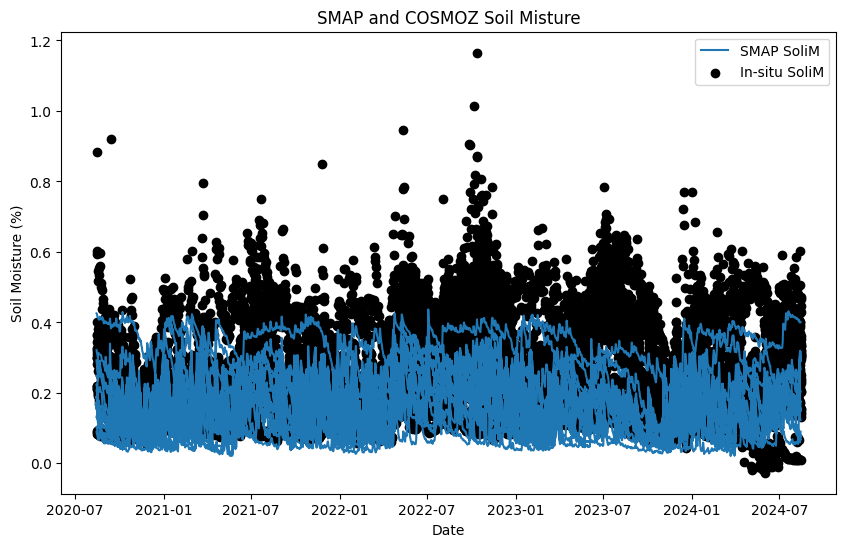

In [12]:
final_merged = pd.read_csv("/content/drive/MyDrive/SoilMoisture/cosmoz/merged_sat_in_situ_data.csv")
final_merged['date'] = pd.to_datetime(final_merged['date'])
final_merged.set_index('date', inplace=True)

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot stacked area chart for col1 and col2
# final_merged[['sm_surface', 'sm_rootzone']].plot(kind='area', stacked=False, ax=ax1, alpha=0.5)
ax1.plot(final_merged.index, final_merged['sm_surface'], label='SMAP SoliM')


# Plot line plot for col3
ax1.scatter(final_merged.index, final_merged['SOIL_MOISTURE_percent'], color='black', label='In-situ SoliM')


# Add labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Soil Moisture (%)')

# Add legends
ax1.legend(loc='upper right')

# Show plot
plt.title('SMAP and COSMOZ Soil Misture')
plt.show()


# Modelling

## Make a general pipeline

In [23]:
final_merged = pd.read_csv("/content/drive/MyDrive/SoilMoisture/cosmoz/merged_sat_in_situ_data.csv")
final_merged['date'] = pd.to_datetime(final_merged['date'])
final_merged.set_index('date', inplace=True)
final_merged.dropna(subset=['SOIL_MOISTURE_percent'], inplace=True)

# percentage of zero in final_merged['precipitation']
zero_percentage = (final_merged['precipitation'] == 0).mean() * 100
print(f"Percentage of zeros in 'precipitation': {zero_percentage:.2f}%")

# therefore, 'precipitation' is dropped due to high missing
final_merged.drop(columns=['precipitation'], inplace=True)

X_all = final_merged[['sm_profile', 'sm_profile_wetness', 'sm_rootzone',
                              'sm_rootzone_wetness', 'sm_surface', 'sm_surface_wetness',
                              'soil_temp_layer1', 'soil_temp_layer2', 'soil_temp_layer3',
                              'soil_temp_layer4', 'soil_temp_layer5', 'soil_temp_layer6',
                              'surface_temp', 'precipitation',
                              'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04',
                              'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07', 'LST_Day_1km',
                              'LST_Night_1km', 'hnd', 'upa', 'elevation']]

X_high_res = final_merged[['sm_profile', 'sm_profile_wetness', 'sm_rootzone',
                              'sm_rootzone_wetness', 'sm_surface', 'sm_surface_wetness',
                              'soil_temp_layer1', 'soil_temp_layer2', 'soil_temp_layer3',
                              'soil_temp_layer4', 'soil_temp_layer5', 'soil_temp_layer6',
                              'surface_temp', 'hnd', 'upa', 'elevation']]

y = final_merged['SOIL_MOISTURE_percent']



Percentage of zeros in 'precipitation': 84.76%


## Data Preparation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, MultiHeadAttention, Input, Dropout, Flatten
from xgboost import XGBRegressor

bands = ['sm_surface', 'sm_rootzone', 'sm_profile', 'sm_surface_wetness', 'sm_rootzone_wetness', 'sm_profile_wetness', 'surface_temp',
          'soil_temp_layer1', 'soil_temp_layer2', 'soil_temp_layer3', 'soil_temp_layer4', 'soil_temp_layer5', 'soil_temp_layer6']

# Prepare features and target
X = merged_df_all[bands].values
y = merged_df_all['SOIL_MOISTURE_percent'].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Transformer Model with MultiHeadAttention

In [ ]:
# import tensorflow as tf

# # Define Transformer model
# def build_transformer_model(input_shape):
#     inputs = Input(shape=input_shape)
#     x = Dense(64, activation='relu')(inputs)
#     x = Dropout(0.2)(x)
#     x = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
#     x = Flatten()(x)
#     x = Dense(32, activation='relu')(x)
#     outputs = Dense(1)(x)

#     model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# # Reshape data for transformer model
# X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# transformer_model = build_transformer_model((1, X_train_scaled.shape[1]))
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# transformer_model.fit(X_train_reshaped, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[callback])


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


356/356 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0106 - val_loss: 0.0045
Epoch 2/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 3/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 4/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 5/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 6/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 7/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 8/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 9/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 10/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 11/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 12/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 13m

## LSTM Model

In [ ]:
# # Define LSTM model
# def build_lstm_model(input_shape):
#     model = Sequential()
#     model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(Flatten())
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model

# # Reshape data for LSTM model
# X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
# X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# lstm_model = build_lstm_model((1, X_train_scaled.shape[1]))
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# lstm_model.fit(X_train_lstm, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[callback])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0192 - val_loss: 0.0049
Epoch 2/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0056 - val_loss: 0.0041
Epoch 3/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 4/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 5/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 6/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 7/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 8/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 9/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 10/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 11/200
356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 12/200
356/356 ━━━━━━━━━━━━━━━━━━━━

## XGBoost Model

In [ ]:
# # Define and train XGBoost model
# xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
# xgb_model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Evaluation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Function to evaluate the model

def evaluate_model(model, X_test, y_test, model_type='keras'):
    if model_type == 'keras':
        y_pred = model.predict(X_test).flatten()
    elif model_type == 'xgboost':
        y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return mse, rmse, r2
# Evaluate Transformer model
transformer_mse, transformer_rmse, transformer_r2 = evaluate_model(transformer_model, X_test_reshaped, y_test, model_type='keras')

# Evaluate LSTM model
lstm_mse, lstm_rmse, lstm_r2 = evaluate_model(lstm_model, X_test_lstm, y_test, model_type='keras')

# Evaluate XGBoost model
xgb_mse, xgb_rmse, xgb_r2 = evaluate_model(xgb_model, X_test_scaled, y_test, model_type='xgboost')

# Create a DataFrame to show the results
results_df = pd.DataFrame({
    'Model': ['Transformer', 'LSTM', 'XGBoost'],
    'MSE': [transformer_mse, lstm_mse, xgb_mse],
    'RMSE': [transformer_rmse, lstm_rmse, xgb_rmse],
    'R-Squared': [transformer_r2, lstm_r2, xgb_r2]
})

results_df


 56/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,Model,MSE,RMSE,R-Squared
0,Transformer,0.002693,0.051897,0.823312
1,LSTM,0.002513,0.050126,0.835165
2,XGBoost,0.001393,0.037323,0.908616


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


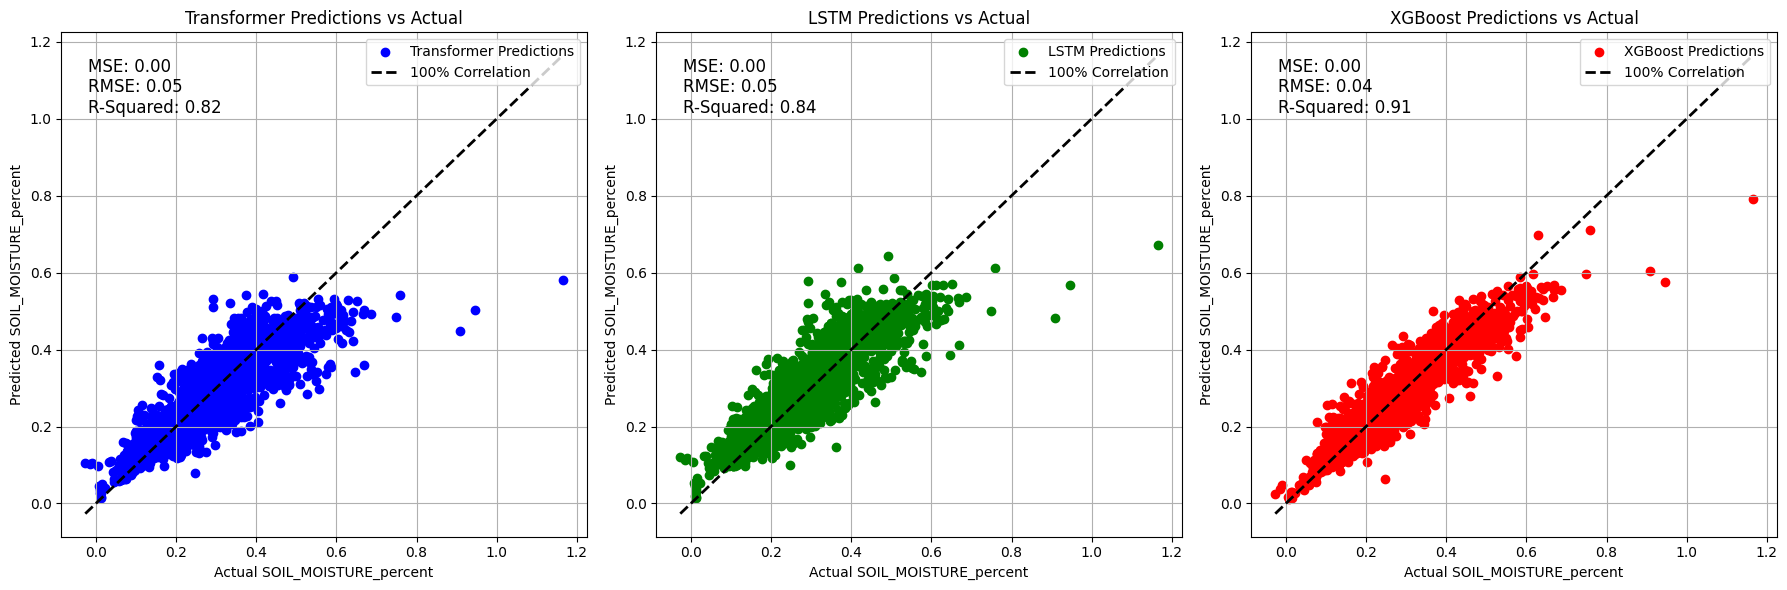

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Generate predictions
transformer_predictions = transformer_model.predict(X_test_reshaped).flatten()
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()
xgb_predictions = xgb_model.predict(X_test_scaled)

# Calculate MSE, RMSE, and R-Squared for each model
transformer_mse = mean_squared_error(y_test, transformer_predictions)
transformer_rmse = np.sqrt(transformer_mse)
transformer_r2 = r2_score(y_test, transformer_predictions)

lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test, lstm_predictions)

xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Plot scatter plots
plt.figure(figsize=(18, 6))

# Transformer model
plt.subplot(1, 3, 1)
plt.scatter(y_test, transformer_predictions, color='blue', label='Transformer Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('Transformer Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {transformer_mse:.2f}\nRMSE: {transformer_rmse:.2f}\nR-Squared: {transformer_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

# LSTM model
plt.subplot(1, 3, 2)
plt.scatter(y_test, lstm_predictions, color='green', label='LSTM Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('LSTM Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {lstm_mse:.2f}\nRMSE: {lstm_rmse:.2f}\nR-Squared: {lstm_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

# XGBoost model
plt.subplot(1, 3, 3)
plt.scatter(y_test, xgb_predictions, color='red', label='XGBoost Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {xgb_mse:.2f}\nRMSE: {xgb_rmse:.2f}\nR-Squared: {xgb_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


# Saving the pipeline

## Create the pipline class

In [ ]:
import joblib
import numpy as np
from tensorflow.keras.models import load_model

class SoilMoisturePredictor:
    def __init__(self, scaler, model):
        self.scaler = scaler
        self.model = model

    def preprocess(self, X):
        # Scale the input features
        X_scaled = self.scaler.transform(X)
        # Reshape for Transformer model
        X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
        return X_reshaped

    def predict(self, X):
        # Preprocess the input
        X_preprocessed = self.preprocess(X)
        # Make predictions using the model
        predictions = self.model.predict(X_preprocessed)
        return predictions

    def save(self, filepath):
        # Save the scaler and model
        joblib.dump(self.scaler, f'{filepath}_scaler.pkl')
        # save_model(self.model, f'{filepath}_model.h5')
        self.model.save(f'{filepath}_model.keras')

    @classmethod
    def load(cls, filepath):
        # Load the scaler and model
        scaler = joblib.load(f'{filepath}_scaler.pkl')
        # model = load_model(f'{filepath}_model.h5')
        model = load_model(f'{filepath}_model.keras')
        return cls(scaler, model)


## Save the pipline

In [ ]:
# Create an instance of SoilMoisturePredictor
predictor = SoilMoisturePredictor(scaler=scaler, model=transformer_model)

# Save the predictor instance
model_path = '/content/drive/MyDrive/SoilMoisture/soil_moisture_predictor'
predictor.save(model_path)



## Save the xgb pipeline

In [ ]:

# Example Preprocessing and Model Pipeline
xgb_pipeline = Pipeline([
    ('scaler', scaler),  # Add other preprocessing steps if necessary
    ('xgb_model', xgb_model)  # Replace with the trained XGBoost model
])

model_path = '/content/drive/MyDrive/SoilMoisture/'

# Save the pipeline
joblib.dump(xgb_pipeline, f'{model_path}xgb_pipeline.pkl')


['/content/drive/MyDrive/SoilMoisture/xgb_pipeline.pkl']

# Load and Use the Encapsulated Model

### Load new satellite data for a different location (site)

In [ ]:
# Parameters
sat_product = 'NASA/SMAP/SPL4SMGP/007'

bands = ['sm_surface', 'sm_rootzone', 'sm_profile', 'sm_surface_wetness', 'sm_rootzone_wetness', 'sm_profile_wetness', 'surface_temp',
         'soil_temp_layer1', 'soil_temp_layer2', 'soil_temp_layer3', 'soil_temp_layer4', 'soil_temp_layer5', 'soil_temp_layer6']

gps = [131.388, -14.159] # station2 (site: Daly)
start_date = datetime(2023, 8, 15)
end_date = datetime(2024, 8, 15)

# Empty list to store DataFrames
dfs = []

# Loop through the date range in 3-month intervals
current_start = start_date
while current_start < end_date:
    current_end = min(current_start + timedelta(days=90), end_date)
    df = download_smap_data(current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d'), sat_product, bands, gps)
    dfs.append(df)
    current_start = current_end

# Combine all DataFrames into one
smap_df_new = pd.concat(dfs)

# Process the combined DataFrame
smap_df_new['date'] = pd.to_datetime(smap_df_new['date'])  # Convert 'date' to datetime
smap_df_new.set_index('date', inplace=True)  # Set 'date' as index


## Load the transformer model and predict new data

In [ ]:
model_path = '/content/drive/MyDrive/SoilMoisture/soil_moisture_predictor'

# Load the predictor instance
model_transformer = SoilMoisturePredictor.load(model_path)

# Resample smap_df to daily and average values
smap_df_daily_new = smap_df_new.resample('D').mean()


# Prepare input for prediction
X_new = smap_df_daily_new[bands].values

# Make predictions using the loaded predictor
transformer_predictions_new = model_transformer.predict(X_new)



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


## Load the xgb model and predict new data

In [ ]:
model_path = '/content/drive/MyDrive/SoilMoisture/'

# Load the pipeline
xgb_pipeline = joblib.load(f'{model_path}xgb_pipeline.pkl')

# Use the pipeline to predict on new data
xgb_predictions_new = xgb_pipeline.predict(X_new)  # new_data will be automatically scaled using the fitted scaler


### Loading in-situ for new data

In [ ]:
staion11_soilM = pd.read_csv('/content/drive/MyDrive/SoilMoisture/station11_level4_1y.csv')
staion11_soilM = staion11_soilM.rename(columns={'UTC_TIMESTAMP': 'date'})
staion11_soilM['date'] = pd.to_datetime(staion11_soilM['date'])
staion11_soilM.set_index('date', inplace=True)
staion11_soilM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8778 entries, 2023-08-15 15:24:08 to 2024-08-15 13:13:40
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SOIL_MOISTURE_percent     8778 non-null   float64
 1   EFFECTIVE_DEPTH_cm        8778 non-null   float64
 2   RAIN_mm                   8778 non-null   float64
 3   7H_SOIL_MOISTURE_percent  8778 non-null   float64
 4   7H_DEPTH_cm               8778 non-null   float64
dtypes: float64(5)
memory usage: 411.5 KB


### Resampling and merging new data

In [ ]:

# Resample staion7_soilM to daily and average values
staion11_soilM_daily = staion11_soilM.resample('D').mean()/100

# Merge the two dataframes on 'date'
merged_df_new = pd.merge(smap_df_daily_new, staion11_soilM_daily, on='date', how='inner')


# Display the merged dataframe
merged_df_new.tail()

,sm_surface,sm_rootzone,sm_profile,sm_surface_wetness,sm_rootzone_wetness,sm_profile_wetness,surface_temp,soil_temp_layer1,soil_temp_layer2,soil_temp_layer3,soil_temp_layer4,soil_temp_layer5,soil_temp_layer6,SOIL_MOISTURE_percent,EFFECTIVE_DEPTH_cm,RAIN_mm,7H_SOIL_MOISTURE_percent,7H_DEPTH_cm
date,,,,,,,,,,,,,,,,,,
2024-08-08,0.162131,0.219471,0.229325,0.359652,0.486848,0.508706,284.248528,283.553940,283.090546,283.584347,285.312046,288.281891,290.508102,0.324797,0.122840,0.0,0.320856,0.123907
2024-08-09,0.161836,0.218925,0.228761,0.358998,0.485636,0.507456,285.265198,284.808247,284.039551,283.789055,285.302616,288.240368,290.506126,0.298267,0.129833,0.0,0.300639,0.129160
2024-08-10,0.156489,0.218055,0.228005,0.347135,0.483707,0.505779,285.239094,285.002403,284.537746,284.092106,285.311031,288.199818,290.504059,0.292472,0.134148,0.0,0.292606,0.133719
2024-08-11,0.146575,0.216936,0.227092,0.325144,0.481225,0.503754,285.794712,285.363602,284.795849,284.365692,285.337177,288.160587,290.501999,0.356514,0.115435,0.0,0.352479,0.117051
2024-08-12,0.142382,0.216215,0.226396,0.315842,0.479625,0.502208,287.065781,286.340179,285.322422,284.635422,285.377296,288.122910,290.499847,0.339771,0.119123,0.0,0.339940,0.119096


### Plot the predictions for new data vs in-situ

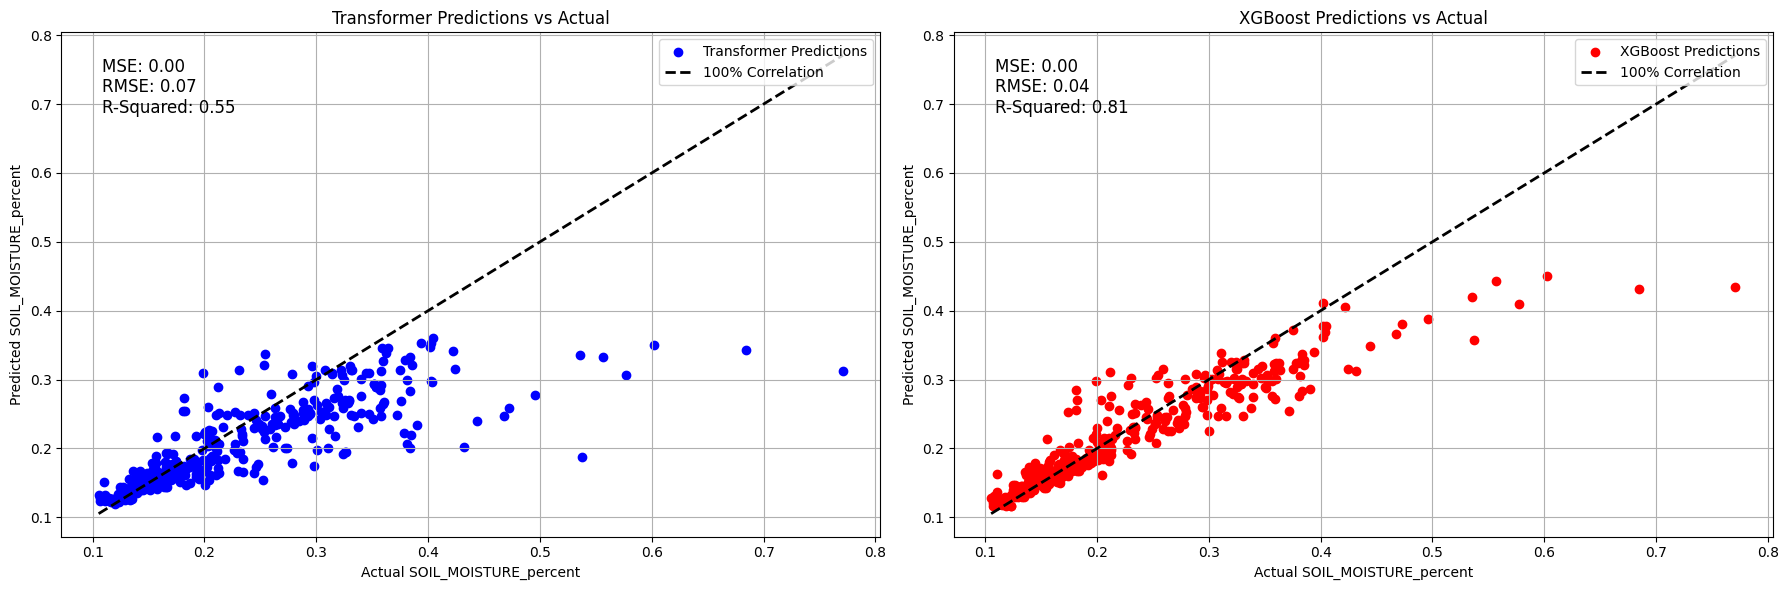

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_test = merged_df_new['SOIL_MOISTURE_percent']

# Generate predictions
transformer_predictions = transformer_predictions_new.flatten()
xgb_predictions = xgb_predictions_new

# Calculate MSE, RMSE, and R-Squared for each model
transformer_mse = mean_squared_error(y_test, transformer_predictions)
transformer_rmse = np.sqrt(transformer_mse)
transformer_r2 = r2_score(y_test, transformer_predictions)


xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Plot scatter plots
plt.figure(figsize=(18, 6))

# Transformer model
plt.subplot(1, 2, 1)
plt.scatter(y_test, transformer_predictions, color='blue', label='Transformer Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('Transformer Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {transformer_mse:.2f}\nRMSE: {transformer_rmse:.2f}\nR-Squared: {transformer_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)


# XGBoost model
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_predictions, color='red', label='XGBoost Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('XGBoost Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {xgb_mse:.2f}\nRMSE: {xgb_rmse:.2f}\nR-Squared: {xgb_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:


# # Plot the actual values and predictions vs date
# plt.figure(figsize=(14, 8))

# plt.plot(merged_df.index, merged_df['SOIL_MOISTURE_percent'], label='SoilM (in-situ)', color='black', linewidth=2)
# plt.plot(merged_df.index, transformer_predictions, label='SoilM (predicted)', color='blue', linestyle='--')
# plt.plot(merged_df.index, merged_df['sm_surface'], label='sm_surface', linewidth=2)
# plt.plot(merged_df.index, merged_df['sm_rootzone'], label='sm_rootzone', linewidth=2)



# plt.title('Model Predictions vs Actual Values Over Time')
# plt.xlabel('Date')
# plt.ylabel('Soil Moisture (%)')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:
# import seaborn as sns

# df = merged_df.copy()
# df['predicted_soilM'] = fresh_predictions
# df['surface_actual'] = df['SOIL_MOISTURE_percent'] - df['sm_surface']
# df['root_actual'] = df['SOIL_MOISTURE_percent'] - df['sm_rootzone']
# df['pred_actual'] = df['SOIL_MOISTURE_percent'] - df['predicted_soilM']

# # Plotting the box plots
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df[['pred_actual', 'surface_actual', 'root_actual']])
# plt.title('Box Plots of Soil Moisture Differences')
# # plt.xlabel('Soil elements')
# plt.ylabel('Error Distribution')
# plt.show()

# Deployment

## Enter gps and date interval

In [ ]:
gps = [146.299, -35.005] # station11 (site: Yanco)
start_date = datetime(2023, 8, 16)
end_date = datetime(2024, 8, 16)

## Load predictors (from satellites)

In [ ]:
def download_smap_data(start_date, end_date, sat_product, bands, gps):
    dates = [start_date, end_date]
    return image_to_df(sat_product, bands, gps, dates)

# Parameters
sat_product = 'NASA/SMAP/SPL4SMGP/007'
bands = ['sm_surface', 'sm_rootzone', 'sm_profile', 'sm_surface_wetness', 'sm_rootzone_wetness', 'sm_profile_wetness', 'surface_temp',
        'soil_temp_layer1', 'soil_temp_layer2', 'soil_temp_layer3', 'soil_temp_layer4', 'soil_temp_layer5', 'soil_temp_layer6']

# Empty list to store DataFrames
dfs = []

# Loop through the date range in 3-month intervals
current_start = start_date
while current_start < end_date:
    current_end = min(current_start + timedelta(days=90), end_date)
    df = download_smap_data(current_start.strftime('%Y-%m-%d'), current_end.strftime('%Y-%m-%d'), sat_product, bands, gps)
    dfs.append(df)
    current_start = current_end

# Combine all DataFrames into one
smap_df = pd.concat(dfs)

# Process the combined DataFrame
smap_df['date'] = pd.to_datetime(smap_df['date'])  # Convert 'date' to datetime
smap_df.set_index('date', inplace=True)  # Set 'date' as index
smap_df.dropna(inplace=True)
smap_df.to_csv(f"/content/drive/MyDrive/SoilMoisture/smap_{gps}.csv")



## Prediction

In [ ]:
model_path = '/content/drive/MyDrive/SoilMoisture/'

# Load the pipeline
xgb_pipeline = joblib.load(f'{model_path}xgb_pipeline.pkl')

# Loading the satellite data related to the selected dates and location
smap_df_new = pd.read_csv(f"/content/drive/MyDrive/SoilMoisture/smap_df_station11.csv")
smap_df_new['date'] = pd.to_datetime(smap_df_new['date'])  # Convert 'date' to datetime
smap_df_new.set_index('date', inplace=True)
smap_df_new.dropna(inplace=True)

# Resample smap_df to daily and average values
smap_df_daily_new = smap_df_new.resample('D').mean()

# Prepare input for prediction
X_new = smap_df_daily_new[bands].values


# Use the pipeline to predict on new data
predictions_new = xgb_pipeline.predict(X_new)  # new_data will be automatically scaled using the fitted scaler

smap_df_daily_new['predicted_soilM'] = predictions_new



## Evaluating the predicted data vs actual data data
(If available)

In [ ]:
# loading in-situ data (cosmoz stations)
cosmoz_data = pd.read_csv(f"/content/drive/MyDrive/SoilMoisture/station11_level4_1y.csv")
cosmoz_data = cosmoz_data.rename(columns={'UTC_TIMESTAMP': 'date'})
cosmoz_data['date'] = pd.to_datetime(cosmoz_data['date'])
cosmoz_data.set_index('date', inplace=True)

# Resample cosmoz data to daily and average values
cosmoz_data_daily = cosmoz_data.resample('D').mean()/100

# Merge the two dataframes on 'date'
merged_df_new = pd.merge(smap_df_daily_new, cosmoz_data_daily, on='date', how='inner')

merged_df_new.dropna(subset=['SOIL_MOISTURE_percent'], inplace=True)

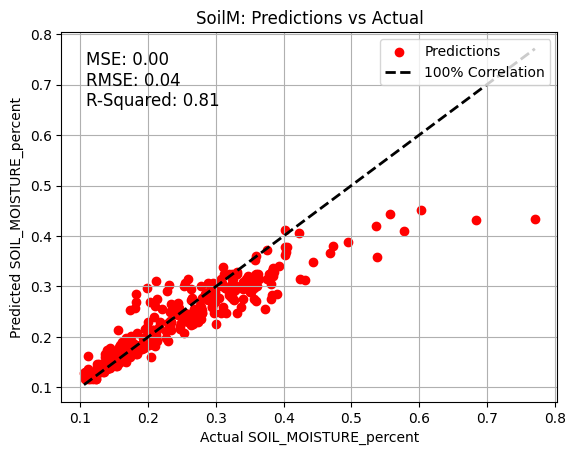

In [ ]:
import numpy as np

# evaluation plot for new data
y_test = merged_df_new['SOIL_MOISTURE_percent']
predictions_new = merged_df_new['predicted_soilM']

# Calculate MSE, RMSE, and R-Squared for each model
new_mse = mean_squared_error(y_test, predictions_new)
new_rmse = np.sqrt(new_mse)
new_r2 = r2_score(y_test, predictions_new)

# Plot scatter plots
# plt.figure(figsize=(18, 6))
plt.scatter(y_test, predictions_new, color='red', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='100% Correlation')
plt.title('SoilM: Predictions vs Actual')
plt.xlabel('Actual SOIL_MOISTURE_percent')
plt.ylabel('Predicted SOIL_MOISTURE_percent')
plt.text(0.05, 0.95, f'MSE: {new_mse:.2f}\nRMSE: {new_rmse:.2f}\nR-Squared: {new_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()


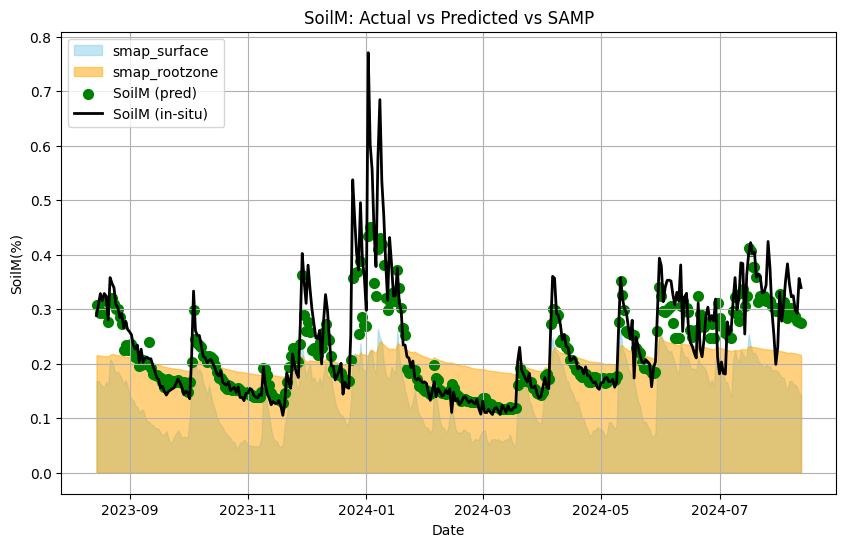

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot col1 and col2 as area charts
ax.fill_between(merged_df_new.index, merged_df_new['sm_surface'], color='skyblue', alpha=0.5, label='smap_surface')
ax.fill_between(merged_df_new.index, merged_df_new['sm_rootzone'], color='orange', alpha=0.5, label='smap_rootzone')

# Plot col3 as a line graph
ax.scatter(merged_df_new.index, merged_df_new['predicted_soilM'], color='green', linewidth=2, label='SoilM (pred)')
ax.plot(merged_df_new.index, merged_df_new['SOIL_MOISTURE_percent'], color='black', linewidth=2, label='SoilM (in-situ)')


# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('SoilM(%)')
ax.set_title('SoilM: Actual vs Predicted vs SAMP')

# Show legend
ax.legend(loc='upper left')

# Show grid
ax.grid(True)

# Display the plot
plt.show()

In [ ]:
merged_df_new.corr()['SOIL_MOISTURE_percent'].sort_values(ascending=False)

,SOIL_MOISTURE_percent
SOIL_MOISTURE_percent,1.000000
7H_SOIL_MOISTURE_percent,0.999650
predicted_soilM,0.928433
sm_surface,0.807256
sm_surface_wetness,0.807254
sm_rootzone,0.708939
sm_rootzone_wetness,0.708935
sm_profile_wetness,0.631838
sm_profile,0.631836
RAIN_mm,0.300957
